In [0]:
from torchvision.datasets import utils
import torch.utils.data as data_utils
import torch
import os
import numpy as np
from torch import nn
from torch.nn.modules import upsampling
from torch.functional import F
from torch.optim import Adam

MINIBATCH=64


In [2]:
# Use the GPU if you have one
if torch.cuda.is_available():
    print("Using the GPU")
    device = torch.device("cuda") 
else:
    print("WARNING: You are about to run on cpu, and this will likely run out \
      of memory. \n You can try setting batch_size=1 to reduce memory usage")
    device = torch.device("cpu")

Using the GPU


In [0]:
def get_data_loader(dataset_location, batch_size):
    URL = "http://www.cs.toronto.edu/~larocheh/public/datasets/binarized_mnist/"
    # start processing
    def lines_to_np_array(lines):
        return np.array([[int(i) for i in line.split()] for line in lines])
    splitdata = []
    for splitname in ["train", "valid", "test"]:
        filename = "binarized_mnist_%s.amat" % splitname
        filepath = os.path.join(dataset_location, filename)
        utils.download_url(URL + filename, dataset_location)
        with open(filepath) as f:
            lines = f.readlines()
        x = lines_to_np_array(lines).astype('float32')
        x = x.reshape(x.shape[0], 1, 28, 28)
        # pytorch data loader
        dataset = data_utils.TensorDataset(torch.from_numpy(x))
        dataset_loader = data_utils.DataLoader(x, batch_size=batch_size, shuffle=(splitname == "train"))
        splitdata.append(dataset_loader)
    return splitdata

In [4]:
train, valid, test = get_data_loader("binarized_mnist", MINIBATCH)

  0%|          | 16384/78400000 [00:00<08:59, 145246.54it/s]

78405632it [00:07, 11042110.65it/s]                             
  0%|          | 49152/15680000 [00:00<00:34, 459179.84it/s]

15687680it [00:01, 11234286.07it/s]                              
  0%|          | 40960/15680000 [00:00<00:39, 392526.61it/s]

15687680it [00:01, 11245698.87it/s]                             


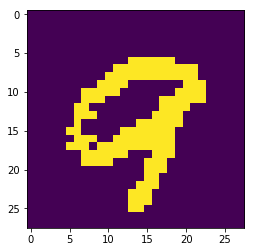

In [5]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
for x in train:
    plt.imshow(x[0,0])
    break


VAE

In [0]:

class Flatten(nn.Module):
  def forward(self, input):
    return input.view(input.size(0), -1)

class unFlatten(nn.Module):
  def forward(self, input):
    return input.view(-1, 256, 1, 1)

class VAE(nn.Module):
  def __init__(self, latent):
    super(VAE, self).__init__()
    self.latent=latent
    self.encoder = nn.Sequential(
      nn.Conv2d(1, 32, 3),
      nn.ELU(),
      nn.AvgPool2d(2, stride=2),
      nn.Conv2d(32, 64, 3),
      nn.ELU(),
      nn.AvgPool2d(2, stride=2),
      nn.Conv2d(64, 256, 5),
      nn.ELU(),
      Flatten(),
      nn.Linear(256, 2*self.latent),
    )

    self.decoder = nn.Sequential(
      nn.Linear(self.latent, 256),
      unFlatten(),
      nn.ELU(),
      nn.Conv2d(256, 64, 5,padding=4),
      nn.ELU(),
      nn.Upsample(scale_factor=2, mode='bilinear'),
      nn.Conv2d(64, 32, 3, padding=2),
      nn.ELU(),
      nn.Upsample(scale_factor=2, mode='bilinear'),
      nn.Conv2d(32, 16, 3,padding=2),
      nn.ELU(),
      nn.Conv2d(16,1,3,padding=2),
      nn.Sigmoid(),
    )
               
 
  def encode(self, x):
    return self.encoder(x)

  def reparameterize(self,MB):
    self.mu,self.log_sigma=self.latent_params[:,:self.latent],self.latent_params[:,self.latent:]
    sigma =torch.exp(self.log_sigma)+1e-7
    e=torch.randn(MB,self.latent).to(device)
    z = self.mu+sigma*e
    return z
    
  def decode(self, z):
    return self.decoder(z)

  def forward(self, x):
    self.latent_params=self.encode(x)
    z= self.reparameterize(x.size()[0])
    x_reconst = self.decode(z)
    return x_reconst, self.mu, self.log_sigma
      


In [0]:

def ELBO(x, x_reconst, mu, log_sigma):
  kl = 0.5 * (-1. -2*log_sigma + mu**2.0+ torch.exp(log_sigma)**2.0).sum(dim=1)
  reconL =(x*torch.log(x_reconst)+(1-x)*torch.log(1-x_reconst)).view(-1,784).sum(dim=1)
  return -(reconL - kl).mean()

In [10]:
model = VAE(100).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0003)
n_epochs=20
  
dataloader = {'Train': train, 'Valid': valid}

for epoch in range(n_epochs):
  print('Training epoch {} of {}'.format(epoch+1,n_epochs))
  for loader in ['Train', 'Valid']:
    accumulated_loss = 0
    print('Phase {}\n'.format(loader))
    if loader == 'Train':
      model.train()
    else:
      model.eval()
    
    iteration=0
    total_iterations=0.1*len(dataloader[loader].dataset)
    total_loss=0
    for x in dataloader[loader]:
      
      optimizer.zero_grad()
      x = x.to(device)
      x_reconst, mu, log_sigma=model(x)
      
      loss =ELBO(x, x_reconst, mu, log_sigma)
      if loader == 'Train':
        loss.backward()
        optimizer.step()
      if iteration*MINIBATCH>=total_iterations:
        print('{:.1f} % of {} phase computed, ELBO : {}'.format(np.round(iteration*MINIBATCH/len(dataloader[loader].dataset)*100,0),loader,-loss.cpu().data.numpy()))
        total_iterations=total_iterations+0.1*len(dataloader[loader].dataset)
      total_loss=(total_loss*iteration+loss.cpu().data.numpy())/(iteration+1)
      iteration=iteration+1
      
    print("Epoch {} ,Average {} ELBO: {:.6f}\n".format(epoch+1,loader,-total_loss))
      
 

Training epoch 1 of 20
Phase Train



/usr/local/lib/python3.6/dist-packages/torch/nn/modules/upsampling.py:129: UserWarning: nn.Upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.{} is deprecated. Use nn.functional.interpolate instead.".format(self.name))
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2423: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


10.0 % of Train phase computed, ELBO : -236.12759399414062
20.0 % of Train phase computed, ELBO : -197.4962615966797
30.0 % of Train phase computed, ELBO : -168.45669555664062
40.0 % of Train phase computed, ELBO : -167.6857452392578
50.0 % of Train phase computed, ELBO : -164.1798553466797
60.0 % of Train phase computed, ELBO : -155.97024536132812
70.0 % of Train phase computed, ELBO : -156.81680297851562
80.0 % of Train phase computed, ELBO : -152.72381591796875
90.0 % of Train phase computed, ELBO : -140.5606689453125
Epoch 1 ,Average Train ELBO: -180.968598

Phase Valid

10.0 % of Valid phase computed, ELBO : -136.99305725097656
20.0 % of Valid phase computed, ELBO : -144.40939331054688
30.0 % of Valid phase computed, ELBO : -139.8754425048828
40.0 % of Valid phase computed, ELBO : -135.61203002929688
51.0 % of Valid phase computed, ELBO : -145.50051879882812
60.0 % of Valid phase computed, ELBO : -139.89239501953125
70.0 % of Valid phase computed, ELBO : -139.05111694335938
80.0 %

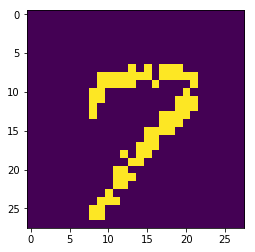

In [11]:
plt.imshow(x[2,0].cpu().data.numpy())

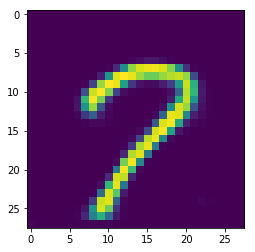

In [12]:
plt.imshow(x_reconst[2,0].cpu().data.numpy())

In [0]:
def logLikelyHood(model,x,z):
  z_dist=torch.distributions.Normal(0,1)
  q_dist=torch.distributions.Normal(model.mu,torch.exp(model.log_sigma)+1e-7)
  for i in range(z.size(1)):
    log_p_z=z_dist.log_prob(z[:,i,:]).sum(dim=1)
    log_q_zx=q_dist.log_prob(z[:,i,:]).sum(dim=1)

    x_reconst = model.decode(z[:,i,:])
    log_p_xz=(x*torch.log(x_reconst.view(-1,784))+(1-x)*torch.log(1-x_reconst.view(-1,784))).sum(dim=1)
    if i==0:
      LLH=(log_p_xz+log_p_z-log_q_zx).unsqueeze(1)
    else:
      LLH=torch.cat((LLH,(log_p_xz+log_p_z-log_q_zx).unsqueeze(1)),dim=1)
      
  return (torch.logsumexp(LLH,dim=1)-np.log(z.size(0))).mean()
    

In [15]:
K=200
model.eval()
for loader in ['Train', 'Valid']:
    print('Phase {}\n'.format(loader))
         
    iteration=0
    total_iterations=0.1*len(dataloader[loader].dataset)
    total_loss=0
    total_LLH=0
    for x in dataloader[loader]:
      x = x.to(device)
      x_reconst, mu, log_sigma=model.forward(x)
      for i in range(K):
        if i==0:
          samples=model.reparameterize(x.size()[0]).unsqueeze(1)
        else:
          samples=torch.cat((samples,model.reparameterize(x.size()[0]).unsqueeze(1)),dim=1)
      
      loss =ELBO(x, x_reconst, mu, log_sigma)
      LLH=logLikelyHood(model,x.view(-1,784),samples)
      if iteration*MINIBATCH>=total_iterations:
        print('{:.1f} % of {} phase computed, ELBO : {}, LLH : {}'.format(np.round(iteration*MINIBATCH/len(dataloader[loader].dataset)*100,0),loader,-loss.cpu().data.numpy(),LLH.cpu().data.numpy()))
        total_iterations=total_iterations+0.1*len(dataloader[loader].dataset)
      total_loss=(total_loss*iteration+loss.cpu().data.numpy())/(iteration+1)
      total_LLH=(total_LLH*iteration+LLH.cpu().data.numpy())/(iteration+1)
      iteration=iteration+1
      
    print("Epoch {} ,Average {} ELBO: {:.6f}, LLH {}\n".format(epoch+1,loader,-total_loss,total_LLH))
      
 

Phase Train



/usr/local/lib/python3.6/dist-packages/torch/nn/modules/upsampling.py:129: UserWarning: nn.Upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.{} is deprecated. Use nn.functional.interpolate instead.".format(self.name))
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2423: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


10.0 % of Train phase computed, ELBO : -95.25047302246094, LLH : -88.77904510498047
20.0 % of Train phase computed, ELBO : -90.23347473144531, LLH : -84.95408630371094
30.0 % of Train phase computed, ELBO : -91.272705078125, LLH : -86.28482818603516
40.0 % of Train phase computed, ELBO : -88.43086242675781, LLH : -82.63607788085938
50.0 % of Train phase computed, ELBO : -94.98233032226562, LLH : -88.78337860107422
60.0 % of Train phase computed, ELBO : -89.93649291992188, LLH : -84.0318603515625
70.0 % of Train phase computed, ELBO : -90.30426025390625, LLH : -84.39012908935547
80.0 % of Train phase computed, ELBO : -94.69538879394531, LLH : -88.666015625
90.0 % of Train phase computed, ELBO : -88.64523315429688, LLH : -81.69587707519531
Epoch 20 ,Average Train ELBO: -93.407870, LLH -87.1272856573315

Phase Valid

10.0 % of Valid phase computed, ELBO : -91.70033264160156, LLH : -85.30870056152344
20.0 % of Valid phase computed, ELBO : -98.30166625976562, LLH : -91.8614273071289
30.0 % 

Sampling our latent variable

In [16]:
e=torch.randn(64,100).to(device)
test_generate = model.decode(e)

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/upsampling.py:129: UserWarning: nn.Upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.{} is deprecated. Use nn.functional.interpolate instead.".format(self.name))
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2423: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


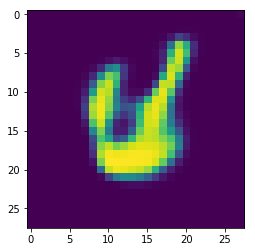

In [154]:
plt.imshow(test_generate[17,0].cpu().data.numpy())

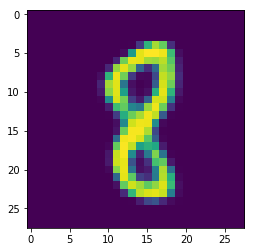

In [162]:
plt.imshow(test_generate[3,0].cpu().data.numpy())

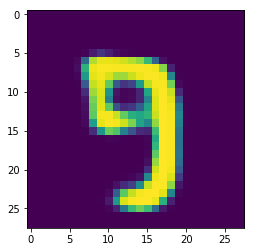

In [19]:
plt.imshow(test_generate[0,0].cpu().data.numpy())